In [1]:
import torch
from PIL import Image
import numpy as np
import torchvision.models as models
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Loading images

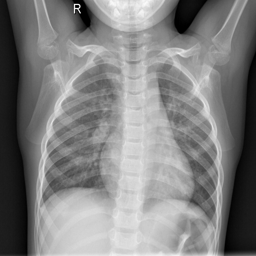

In [5]:
img = Image.open('chest_xray/train/NORMAL/IM-0115-0001.jpeg').convert("RGB")
img.resize((256, 256))

In [59]:
X = np.array(img.resize((224, 224)))
X

array([[[ 22,  22,  22],
        [ 20,  20,  20],
        [ 19,  19,  19],
        ...,
        [ 95,  95,  95],
        [ 95,  95,  95],
        [ 95,  95,  95]],

       [[ 22,  22,  22],
        [ 21,  21,  21],
        [ 19,  19,  19],
        ...,
        [ 93,  93,  93],
        [ 95,  95,  95],
        [ 95,  95,  95]],

       [[ 23,  23,  23],
        [ 21,  21,  21],
        [ 19,  19,  19],
        ...,
        [ 94,  94,  94],
        [ 94,  94,  94],
        [ 93,  93,  93]],

       ...,

       [[ 29,  29,  29],
        [ 29,  29,  29],
        [ 27,  27,  27],
        ...,
        [ 59,  59,  59],
        [ 60,  60,  60],
        [ 60,  60,  60]],

       [[ 34,  34,  34],
        [ 35,  35,  35],
        [ 34,  34,  34],
        ...,
        [ 80,  80,  80],
        [ 82,  82,  82],
        [ 82,  82,  82]],

       [[ 46,  46,  46],
        [ 46,  46,  46],
        [ 45,  45,  45],
        ...,
        [109, 109, 109],
        [110, 110, 110],
        [111, 111, 111]]

In [60]:
X.shape

(224, 224, 3)

## Using a Pre-trained convolutional neural network to make a prediction

In [2]:
model = models.densenet121(weights='IMAGENET1K_V1')

model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
x = preprocess(img)

batch_t = torch.unsqueeze(x, 0)

with torch.no_grad():
    output = model(batch_t)

_, indices = torch.sort(output, descending=True)

In [64]:
print(output)

tensor([[-2.8715e+00,  3.8927e+00, -1.0102e+00,  2.3180e+00,  1.9180e+00,
         -1.0565e+00,  4.9439e-02, -1.7771e+00, -1.6013e+00, -7.6558e-01,
         -2.7442e+00, -1.9195e+00,  1.0781e+00, -6.9439e-01, -2.5104e+00,
         -7.3937e-01, -3.5466e-01, -1.8304e+00, -2.4610e+00,  5.0528e-01,
         -2.3011e+00,  1.4777e-01, -1.4341e+00,  3.2514e-01, -1.6196e+00,
         -1.3461e+00, -2.1923e+00, -1.9644e+00, -1.5232e+00,  1.7120e+00,
         -3.1117e+00, -1.9013e+00, -2.1998e+00,  2.2648e+00,  1.8946e+00,
          3.9886e-02,  1.4756e-01,  1.3765e+00,  3.1510e-01, -9.2376e-01,
         -2.7771e+00, -1.3557e+00, -2.6200e+00, -1.2351e+00,  8.2432e-01,
          1.6935e+00, -2.0618e+00, -1.7087e+00, -1.2426e+00, -3.3229e+00,
         -4.2160e-01, -7.2678e-01,  2.7007e+00,  4.7619e-01,  4.1384e+00,
          2.0010e+00,  2.4054e+00,  7.6868e-01,  2.2514e+00,  8.1854e-01,
          3.0976e+00,  2.1428e+00,  1.9054e+00,  7.1661e+00,  3.2819e+00,
          9.6789e-01,  2.2421e+00,  3.

In [65]:
output_np = output.detach().cpu().numpy()
print(len(output_np[0]))

1000


As seen from the output of the previous cell, the pretrained DenseNet model outputs a 1×1000 tensor of logits, where each value represents the model’s raw score for one of the 1000 ImageNet classes. The class with the highest score is the model’s predicted class. Adapting the model to our use case in this project which requires only 2 output classes, normal or pneumonia leads us to transfer learning

## Transfer learning and adding custom output layer for this project 

In [7]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [9]:
train_dataset = ChestXrayDataset(data_dir='./chest_xray/train',transform=train_transforms)
val_dataset = ChestXrayDataset( data_dir='./chest_xray/test', transform=test_transforms ) # Using test as val data on purpose cause val dataset is too small

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train images:", len(train_dataset))
print("Val images:", len(val_dataset))

Train images: 5216
Val images: 624


## Exploratory Data Analysis

In [10]:
from collections import Counter

no_train_images = Counter(train_dataset.labels)
no_val_images = Counter(val_dataset.labels)

train_counts = dict(no_train_images)
val_counts = dict(no_val_images)

print("Train images:", train_counts)
print("Val images:", val_counts)

Train images: {0: 1341, 1: 3875}
Val images: {0: 234, 1: 390}


In [11]:
label_map = {i: cls for i, cls in enumerate(train_dataset.classes)} #Since ChestXrayDataset looks like this 'self.labels = [...]' internally

def convert_counts(counter, label_map):
    return {label_map[k]: v for k, v in counter.items()}

print("Train images:", convert_counts(no_train_images, label_map))
print("Val images:", convert_counts(no_val_images, label_map))

# Alternatively
# This take quite some time to run compared to the code in previous cell
# from collections import Counter

# def dataset_class_counts(dataset):
#     labels = [dataset[i][1] for i in range(len(dataset))]
#     return Counter(labels)

# train_counts = dataset_class_counts(train_dataset)
# val_counts = dataset_class_counts(val_dataset)

# label_map = {
#     0: 'NORMAL',
#     1: 'PNEUMONIA'
# }

# def map_counter(counter, label_map):
#     return {label_map[k]: v for k, v in counter.items()}

# print("Train:", map_counter(train_counts, label_map))
# print("Val:", map_counter(val_counts, label_map))

Train images: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Val images: {'NORMAL': 234, 'PNEUMONIA': 390}


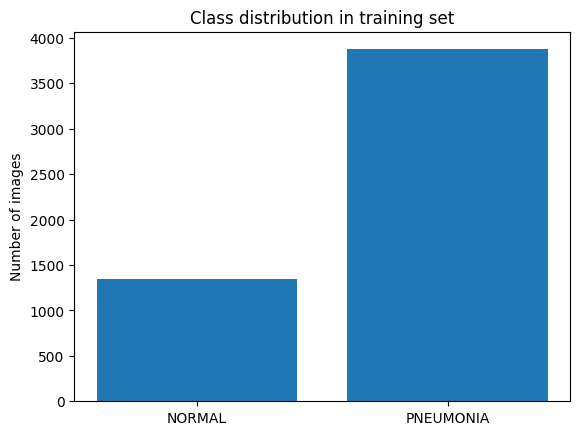

In [12]:
import matplotlib.pyplot as plt

labels = ["NORMAL", "PNEUMONIA"]
counts = [train_counts[0], train_counts[1]]

plt.bar(labels, counts)
plt.title("Class distribution in training set")
plt.ylabel("Number of images")
plt.show()

In [72]:
class ChestXrayClassifierDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ChestXrayClassifierDenseNet, self).__init__()

        # Load pre-trained DenseNetV2
        self.base_model = models.densenet121(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ChestXrayClassifierDenseNet(num_classes=2)
model.to(device)

ChestXrayClassifierDenseNet(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, 

In [74]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training loop
num_epochs = 6

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/6
  Train Loss: 0.1854, Train Acc: 0.9317
  Val Loss: 0.4665, Val Acc: 0.8638
Epoch 2/6
  Train Loss: 0.1689, Train Acc: 0.9415
  Val Loss: 0.5094, Val Acc: 0.8574
Epoch 3/6
  Train Loss: 0.1533, Train Acc: 0.9494
  Val Loss: 0.4493, Val Acc: 0.8878
Epoch 4/6
  Train Loss: 0.2141, Train Acc: 0.9417
  Val Loss: 0.6201, Val Acc: 0.8686
Epoch 5/6
  Train Loss: 0.1684, Train Acc: 0.9532
  Val Loss: 0.5236, Val Acc: 0.8910
Epoch 6/6
  Train Loss: 0.1483, Train Acc: 0.9538
  Val Loss: 0.6688, Val Acc: 0.8654


In [20]:
num_epochs = 2

In [21]:
def make_model(learning_rate=0.01):
    model = ChestXrayClassifierDenseNet(num_classes=2)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [ ]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'model_v4_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

In [ ]:
for lr in [0.001, 0.1, 1, 10]:
  print("learning rate =", lr)
  model, optimizer = make_model(lr)
  train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

learning rate = 0.001
Epoch 1/2
  Train Loss: 0.2145, Train Acc: 0.9181
  Val Loss: 0.2279, Val Acc: 0.9375
Checkpoint saved: model_v4_01_0.938.pth
Epoch 2/2
  Train Loss: 0.1346, Train Acc: 0.9500
  Val Loss: 0.2165, Val Acc: 1.0000
Checkpoint saved: model_v4_02_1.000.pth
learning rate = 0.1
Epoch 1/2
  Train Loss: 1.2352, Train Acc: 0.9128
  Val Loss: 3.3518, Val Acc: 0.7500
Checkpoint saved: model_v4_01_0.750.pth
Epoch 2/2
  Train Loss: 1.2749, Train Acc: 0.9312
  Val Loss: 2.8862, Val Acc: 0.8750
Checkpoint saved: model_v4_02_0.875.pth
learning rate = 1
Epoch 1/2
  Train Loss: 14.0506, Train Acc: 0.9168
  Val Loss: 5.5475, Val Acc: 0.9375
Checkpoint saved: model_v4_01_0.938.pth
Epoch 2/2
  Train Loss: 16.7835, Train Acc: 0.9291
  Val Loss: 10.4898, Val Acc: 0.8125
learning rate = 10
Epoch 1/2
  Train Loss: 138.7353, Train Acc: 0.9132
  Val Loss: 155.0629, Val Acc: 0.8750
Checkpoint saved: model_v4_01_0.875.pth
Epoch 2/2
  Train Loss: 103.6446, Train Acc: 0.9362
  Val Loss: 345.7739

learning_rate = 0.001 is the most appropriate value for learning_rate since Validation accuracy goes up to 1.000 and the loss in minimum

## Using Trained Model

In [ ]:
# import glob, os

# Find best checkpoint
# list_of_files = glob.glob('model_v4_*.pth')
# latest_file = max(list_of_files, key=os.path.getctime)
# print(f"Loading model from: {latest_file}")

Loading model from: model_v4_01_0.938.pth


In [ ]:
model_path = './model_v4_02_1.000.pth'

# Load model
model = ChestXrayClassifierDenseNet(num_classes=2)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

/tmp/ipykernel_1214/2047339873.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


ChestXrayClassifierDenseNet(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, 

In [24]:
x = val_transforms(img)
batch_t = torch.unsqueeze(x, 0).to(device)

with torch.no_grad():
    output = model(batch_t)

In [25]:
print(output)

tensor([[ 2.2703, -1.9680]], device='cuda:0')


In [26]:
classes = ['NORMAL', 'PNEUMONIA']

In [27]:
dict(zip(classes, output[0].to('cpu')))

{'NORMAL': tensor(2.2703), 'PNEUMONIA': tensor(-1.9680)}